### Cell 0: ( Only for Colab ) Install the git **repository**

In [1]:
import sys
import os

# 1. Clone the repository
!git clone -b trajectory_tracking_policy https://github.com/orc-podavini-grisenti/final_assignment

# 2. Point the project_root specifically to the cloned folder
# In Colab, the folder structure will be /content/final_assignment/
project_root = os.path.abspath('/content/final_assignment')

# 3. Add that specific folder to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


# 4. Link the Drive to the colab in order to store the results
from google.colab import drive
drive.mount('/content/drive')

SAVE_ON_DRIVE = True
drive_path = "/content/drive/MyDrive/final_assignment/models_saved"

# Crea la cartella se non esiste
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

Cloning into 'final_assignment'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 98 (delta 30), reused 93 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 289.48 KiB | 2.95 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Mounted at /content/drive


### Cell 1: Imports & Setup

In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from planner.dubins_planner import DubinsPlanner
from models.trajectory_tracking_network import TTNetwork

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


### Cell 2: Load Training Hyperparameters

In [3]:
# Hyperparameters
MAX_EPISODES = 200
MAX_STEPS = 200
LR = 1e-3
BATCH_SIZE = 5
GAMMA = 0.99

### Cell 3: Intialization

In [ ]:
# Init Enviroment and Dubins Planner
env = UnicycleEnv()
planner = DubinsPlanner(curvature_max=1.5, step_size=0.2)


# Initilize the Network.
obs_dim = 3     # Obs dim is 3 (rho, alpha, d_theta)
action_dim = 2  # v, omega

policy = TTNetwork(obs_dim, action_dim).to(device)

optimizer = optim.Adam(policy.parameters(), lr=LR)

gamma = GAMMA

# Memory buffer for the current episode
log_probs = []
rewards = []

# Memory buffer fot the current batch
batch_losses = [] # Store losses from multiple episodes of the same batch
loss_history = [] # Store all the batch losses

### Cell 4: Helpers

In [ ]:
def get_action(obs):
    """Samples an action and stores its log_probability."""
    obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)

    # Call the network to get a action distribution
    mean, std = policy(obs_t)
    dist = Normal(mean, std)

    # Sample a randome action from this distribution
    # NB: randomcicity ensure exploration
    action = dist.sample()

    # Store log_prob for the update step later
    # Sum over action dimensions (v and omega)
    log_prob = dist.log_prob(action).sum(dim=1)
    log_probs.append(log_prob)

    # Return numpy action for the environment
    # Clip to ensure physical validity [-1, 1]
    return np.clip(action.cpu().detach().numpy()[0], -1.0, 1.0)


def store_reward(reward):
    rewards.append(reward)

def store_batch_loss(loss):
    loss_history.append(loss)

### Cell 5: Reinforce Update

In [ ]:
def calculate_episode_loss():
    """Calculates loss for a SINGLE trajectory (Inner Sum)"""
    global log_probs, rewards, batch_losses

    R = 0
    returns = []

    # 1. Calculate Cost To Go (Backwards)
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns).to(device)

    # 2. Normalize Returns (Crucial for stability!)
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    # 3. Compute Loss
    # Action Loss = log_prob * C_t
    policy_loss = []
    for log_prob, G_t in zip(log_probs, returns):
        policy_loss.append(-log_prob * G_t)

    # The episode loss is the sum of all action loss
    loss = torch.stack(policy_loss).sum()

    # Store the episode loss in the batch losses buffer
    batch_losses.append(loss)

    # Clear step-wise memory for the next episode in the batch
    log_probs = []
    rewards = []



"""Monte Carlo Policy Gradient Update"""
def update():
    global batch_losses # Needed to modify the global list
    # Updates policy using the mean of the collected batch (Outer Mean).
    if not batch_losses:        # security check to the batch losses
        return

    # 1. Average over 'm' trajectories
    # loss = (1/m) * sum(episode_losses)
    batch_loss = torch.stack(batch_losses).mean()

    # 2. Backpropagate
    optimizer.zero_grad()       # reset the optimizer
    batch_loss.backward()       # compute the gradient
    optimizer.step()            # update the weight of the network

    # 3. Clear Batch Memory
    store_batch_loss(batch_loss)    # save the batch loss to plotting
    batch_losses = []   

### Cell 6: Training

In [7]:
reward_history = []

print("Starting Training...")

for episode in range(MAX_EPISODES):
    # 1. Reset & Plan
    obs, info = env.reset()
    start_pose = env.state
    goal_pose = env.goal

    # Generate Reference Trajectory
    path = planner.get_path(start_pose, goal_pose)
    if path is None: continue # Skip hard planning cases

    path_idx = 0
    ep_reward = 0

    # 2. Episode Rollout
    for t in range(MAX_STEPS):
        # A. Determine Target
        target = path[path_idx]

        # B. Observation (Relative to Waypoint)
        # Extract only the first 3 element: [rho, alpha, d_theta]
        # Discard the obstacle part, in the first section are not relevant
        tracking_obs = obs[:3]

        # C. Action
        action = get_action(tracking_obs)

        # D. Step
        # We ignore env reward, we calculate our own
        obs, reward, terminated, truncated, info = env.step(action)

        # E. Reward
        store_reward(reward)
        ep_reward += reward

        # F. Update Waypoint (Pure Pursuit Logic)
        # If close to current waypoint, target the next one
        if tracking_obs[0] < 0.1 and path_idx < len(path) - 1:
            path_idx += 1

        # G. Termination
        dist_to_final = np.linalg.norm(env.state[:2] - goal_pose[:2])
        if dist_to_final < 0.1 and path_idx == len(path) - 1:
            # Success!
            break
        if info['collision']:
            break

    # 3. Compute the Episode loss
    calculate_episode_loss()

    # 4. If we have collected 'm' trajectories, perform the update
    if (episode + 1) % BATCH_SIZE == 0:
        update() # This effectively divides by m
        print(f"Update performed at episode {episode}")

    reward_history.append(ep_reward)

    if (episode + 1) % BATCH_SIZE == 0:
        avg_r = np.mean(reward_history[-20:])
        print(f"Episode {episode} | Avg Reward: {avg_r:.1f} | Path Len: {len(path)}")

print("Training Complete.")

Starting Training...
Update performed at episode 4
Episode 4 | Avg Reward: -819.7 | Path Len: 17
Update performed at episode 9
Episode 9 | Avg Reward: -891.9 | Path Len: 9
Update performed at episode 14
Episode 14 | Avg Reward: -960.2 | Path Len: 15
Update performed at episode 19
Episode 19 | Avg Reward: -978.3 | Path Len: 13
Update performed at episode 24
Episode 24 | Avg Reward: -1052.7 | Path Len: 29
Update performed at episode 29
Episode 29 | Avg Reward: -1071.2 | Path Len: 31
Update performed at episode 34
Episode 34 | Avg Reward: -1057.6 | Path Len: 27
Update performed at episode 39
Episode 39 | Avg Reward: -1105.4 | Path Len: 16
Update performed at episode 44
Episode 44 | Avg Reward: -1149.6 | Path Len: 26
Update performed at episode 49
Episode 49 | Avg Reward: -1219.8 | Path Len: 28
Update performed at episode 54
Episode 54 | Avg Reward: -1251.0 | Path Len: 12
Update performed at episode 59
Episode 59 | Avg Reward: -1283.5 | Path Len: 14
Update performed at episode 64
Episode 6

### Cell 7: Visualization & Save
Plot the learning curve to verify convergence.

Results will be saved to: /content/drive/MyDrive/final_assignment/models_saved/experiments/run_20260101_162230


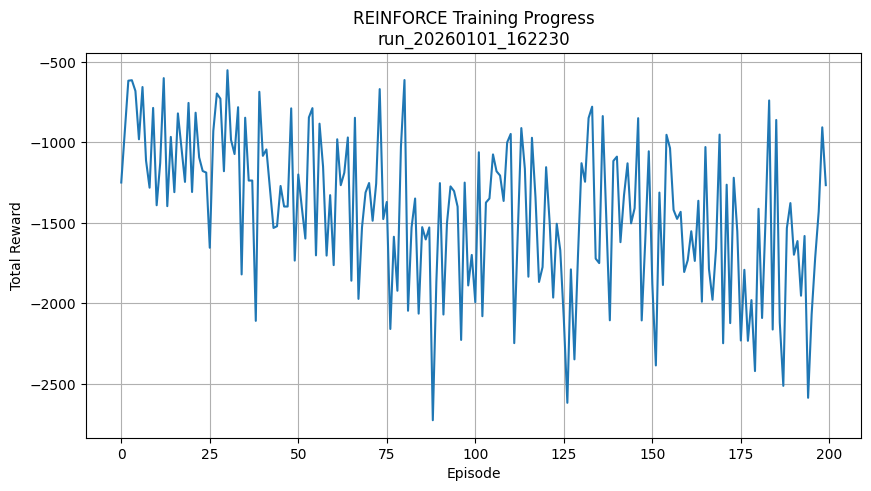

------------------------------
Execution complete.
Model saved: policy_model.pth
Plot saved: training_reward_plot.png
Raw data saved: reward_history.npy
------------------------------


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- 1. SETUP DIRECTORY STRUCTURE ---
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"run_{current_time}"

if SAVE_ON_DRIVE:
    base_output_path = os.path.join(drive_path, "experiments")
else:
    base_output_path = "experiments"

output_dir = os.path.join(base_output_path, run_id)
os.makedirs(output_dir, exist_ok=True)

print(f"Results will be saved to: {output_dir}")

# --- 2. PLOTTING AND SAVING FIGURES ---
# We create a figure with 2 subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total Reward
ax1.plot(reward_history, color='blue')
ax1.set_title("Training Reward")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Total Reward")
ax1.grid(True)

# Plot 2: Training Loss
# Note: Ensure you are appending your loss values to a list named 'loss_history' during training
ax2.plot(loss_history, color='red')
ax2.set_title("Training Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Loss")
ax2.grid(True)

plt.suptitle(f"REINFORCE Training Metrics - {run_id}")
plt.tight_layout() # Adjust spacing so titles don't overlap

# Save the combined plot
plot_filename = "training_metrics_plot.png"
plt.savefig(os.path.join(output_dir, plot_filename))
plt.show()

# --- 3. SAVING MODEL AND DATA ---
model_filename = "policy_model.pth"
torch.save(policy.state_dict(), os.path.join(output_dir, model_filename))

# Save both histories for future analysis
np.save(os.path.join(output_dir, "reward_history.npy"), np.array(reward_history))
np.save(os.path.join(output_dir, "loss_history.npy"), np.array(loss_history))

print("-" * 30)
print(f"Execution complete.")
print(f"Directory: {output_dir}")
print(f"Saved: {model_filename}, {plot_filename}, histories (.npy)")
print("-" * 30)

### Cell 8: ⚠ Delete the train directory ( only for bed results )

In [9]:
import shutil

# --- DELETE CURRENT EXPERIMENT DIRECTORY ---
# Ask for confirmation to prevent accidental deletion
confirm = input(f"Do you want to delete the directory '{run_id}'? (y/n): ")

if confirm.lower() == 'y':
    try:
        # shutil.rmtree deletes a directory and all its contents
        shutil.rmtree(output_dir)
        print(f"Successfully deleted: {output_dir}")
    except OSError as e:
        print(f"Error: {e.strerror}. Could not delete the directory.")
else:
    print("Deletion cancelled. Experiment results preserved.")

Do you want to delete the directory 'run_20260101_162230'? (y/n): y
Successfully deleted: /content/drive/MyDrive/final_assignment/models_saved/experiments/run_20260101_162230
